In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

In [2]:
!curl -L -o /content/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    244      0 --:--:--  0:00:01 --:--:--   244
100   491    0   491    0     0    278      0 --:--:--  0:00:01 --:--:--     0
100  202M  100  202M    0     0  38.8M      0  0:00:05  0:00:05 --:--:-- 73.8M


In [3]:
!tar xfv /content/archive.tar.gz -C /content

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [4]:
IMAGE_PATH="/content/archive/images/"
ANNOTATIONS_PATH = "/content/archive/annotations/"

In [19]:

def generate_dataframe_from_xml_annotations(directory):
    path = glob(directory)
    labels_dict = dict(image=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        image_name = os.path.basename(filename)  # Obter apenas o nome do arquivo sem o caminho
        image_name = image_name.replace(".xml", ".png")  # Substituir a extensão .xml por .png

        labels_dict['image'].append(image_name)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    return df

In [57]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml')
df

,image,xmin,xmax,ymin,ymax
0,Cars260.png,170,232,112,129
1,Cars415.png,133,261,157,192
2,Cars430.png,38,116,159,197
3,Cars132.png,23,56,190,198
4,Cars97.png,98,297,102,191
...,...,...,...,...,...
428,Cars176.png,72,308,67,185
429,Cars366.png,144,316,112,160
430,Cars141.png,266,307,169,188
431,Cars303.png,150,247,211,237


In [58]:
import tensorflow as tf

def make_dataset(row):
    img = tf.io.read_file(IMAGE_PATH + row)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    return img

data = list(map(make_dataset, df.image.values))

In [61]:
tsst = np.array(data)

In [71]:
train_ds = tf.data.Dataset.from_tensor_slices((data, (df.xmin.values, df.ymin.values, df.xmax.values, df.ymax.values)))

In [74]:
rescaling = layers.Rescaling(scale=1./127.5, offset=-1)
resizing = layers.Resizing(64, 64)

In [75]:
train_ds = train_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [76]:
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [77]:

from tensorflow.keras import layers

img_input = layers.Input(shape=(64, 64, 3))

x = rescaling(img_input)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
final = layers.Dropout(0.2)(x)

a = layers.Dense(1, name="a")(final)
b = layers.Dense(1, name="b")(final)
c = layers.Dense(1, name="c")(final)
d = layers.Dense(1, name="d")(final)

model = tf.keras.Model(img_input, [a, b, c, d])

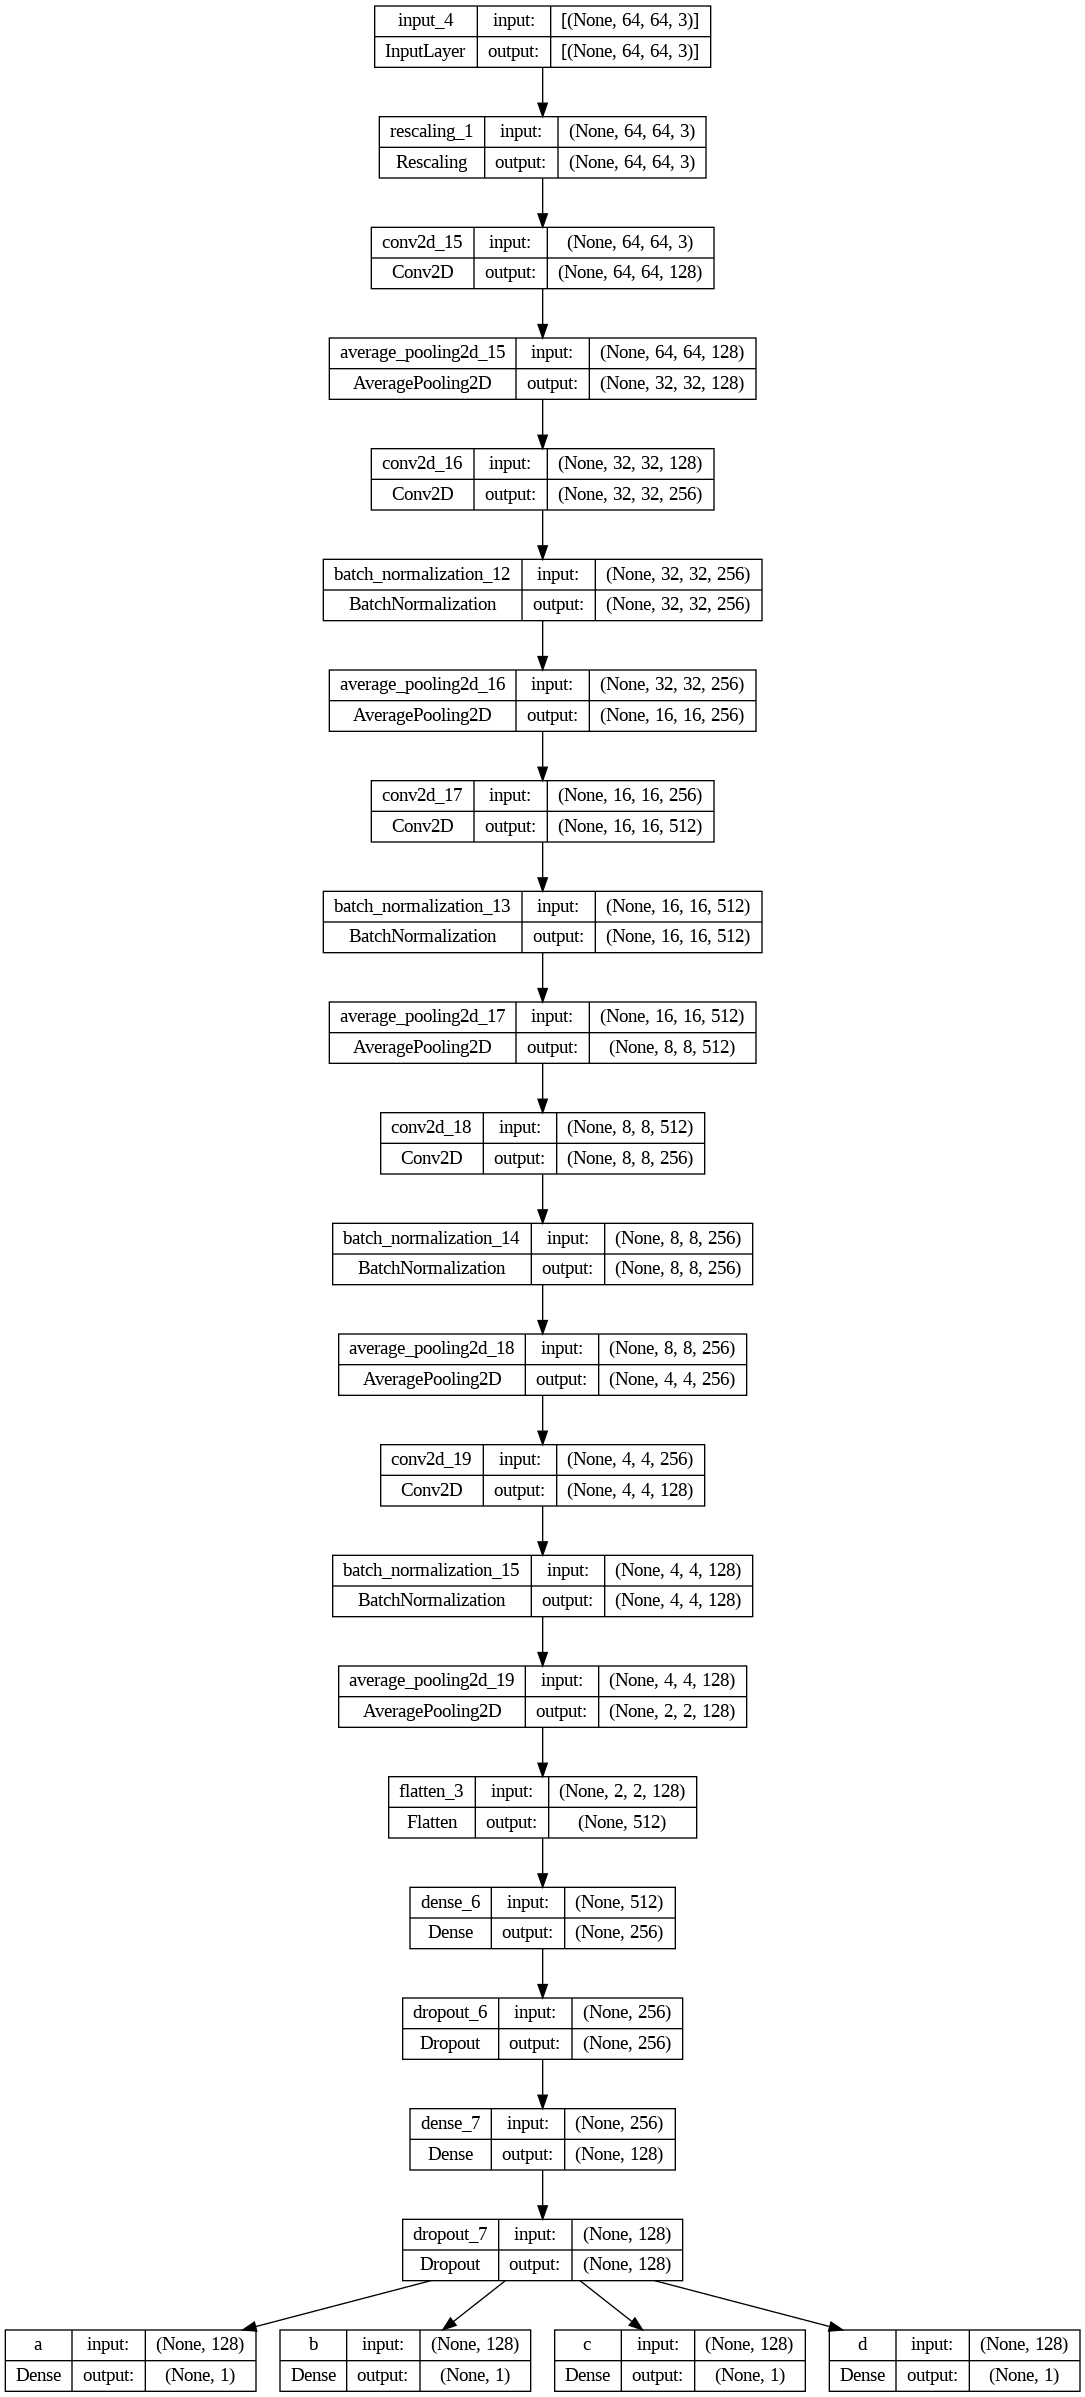

In [78]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [79]:
model.compile(optimizer="adam", loss={
    "a": tf.keras.losses.MeanAbsoluteError(),
    "b": tf.keras.losses.MeanAbsoluteError(),
    "c": tf.keras.losses.MeanAbsoluteError(),
    "d": tf.keras.losses.MeanAbsoluteError()
})

In [81]:
model.fit(train_ds, epochs=10)


Epoch 1/10
4/4 [==============================] - 43s 10s/step - loss: 715.0496 - a_loss: 146.7758 - b_loss: 141.6700 - c_loss: 249.0032 - d_loss: 177.6005
Epoch 2/10
4/4 [==============================] - 43s 10s/step - loss: 638.9992 - a_loss: 128.3910 - b_loss: 121.6470 - c_loss: 232.1085 - d_loss: 156.8528
Epoch 3/10
4/4 [==============================] - 45s 10s/step - loss: 525.2790 - a_loss: 102.4761 - b_loss: 91.2721 - c_loss: 206.5631 - d_loss: 124.9678
Epoch 4/10
4/4 [==============================] - 44s 10s/step - loss: 380.9550 - a_loss: 74.4948 - b_loss: 54.0245 - c_loss: 170.5422 - d_loss: 81.8935
Epoch 5/10
4/4 [==============================] - 45s 11s/step - loss: 289.3763 - a_loss: 70.1604 - b_loss: 49.2172 - c_loss: 123.1010 - d_loss: 46.8977
Epoch 6/10
4/4 [==============================] - 43s 10s/step - loss: 278.8584 - a_loss: 77.4691 - b_loss: 63.4652 - c_loss: 84.4351 - d_loss: 53.4890
Epoch 7/10
4/4 [==============================] - 44s 10s/step - loss: 243.

In [83]:
import cv2
def produce_bounding_box(image):
    test_img = tf.io.read_file(image)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = [int(x.numpy()[0][0]) for x in model(test_img)]

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bounded = cv2.rectangle(img, (outputs[0], outputs[1]), (outputs[2], outputs[3]), (0,255,0), 4)

    return bounded

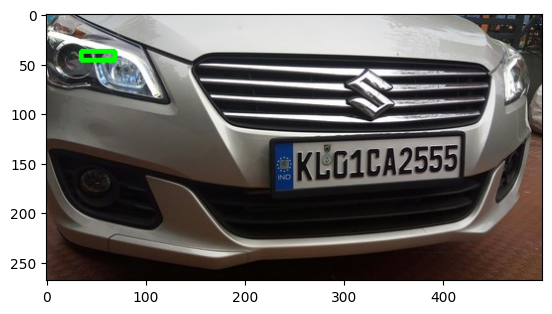

In [84]:
import matplotlib.pyplot as plt
plt.imshow(produce_bounding_box("/content/archive/images/Cars0.png"))